# Employing the Quantum SafeML method on a Quantum kernel Classifier

## Overview
Quantum SafeML has been devised as a safety Monitoring method for QML classification, which makes use of quantum statistical distance emtrics in order to garner insigth on model performance, accuracy, and prediction confidence.

Ideally, the quantum safeMl method can be suited to most types of QML classification problem=ms, provided the given dataset and prediction format of the specific QML model are of like types that are comptaible with the operation of the underlying distance metrics. Specifcally, the metrics chosen for the safety monitorign methodology.

In this notebook, based off of Qiskit's [Quantum kernel Tutorial](https://github.com/qiskit-community/qiskit-machine-learning/blob/stable/0.8/docs/tutorials/03_quantum_kernel.ipynb), We will instantiate A Quantum classifier model through the use of Kernel Methods, which will 

In [1]:
from qiskit_machine_learning.utils import algorithm_globals

algorithm_globals.random_seed = 202222914

In [2]:
import matplotlib.pyplot as plt
import numpy as np

## Creating an ad hoc dataset

For assesement of the QML model, we first construct an ad-hoc dataset. This can be done directly with [Qiskit Machine learning's built in ad hoc data constructor](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.datasets.ad_hoc_data.html). ad hoc data essentially allows us to specify the exact dimensionality and composition of our dataset, even specifying the level of "gap" between the two sets. In this case, we give it only a dimensionality of 2 for simple binary example. This ad hoc feature also can lend itself to the particular circumstances QML models operate within. 

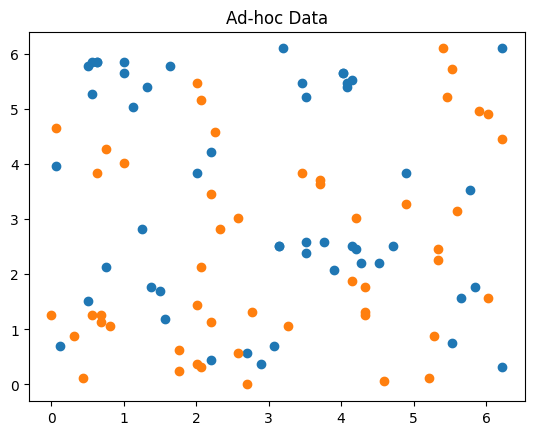

In [3]:
from qiskit_machine_learning.datasets import ad_hoc_data

adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=50,
    test_size=15,
    n=adhoc_dimension,
    gap=0.1,
    plot_data=True,
    one_hot=False,
    include_sample_total=True,
)

## Visualising the dataset
Below, we specify fucntions for plotting individual featrues and the overall dataset into an interprettable space, in hwich we make use of color mapping in order to view the intircacies in areas of featrues values the distinct labels occupy. Specifically, in this instance we notice a wide spread of datapoints for class b spanning much of the space, with sporadic Pockets of green which denotes clusters of datapoints belonging to class A. this visualisation is suited to the specific ad hoc data we instantiated, but perhaps a dataset made with higher dimensionality would require a more intricate detail then just a divergent color background.

In any case, what we interpret from this visualisation is that the distribution of both classes is indeed distinct, but not linearly, and there are intricate patterns that intertwine them that a QML model will have to pick up on in order to adequately fit to the data.


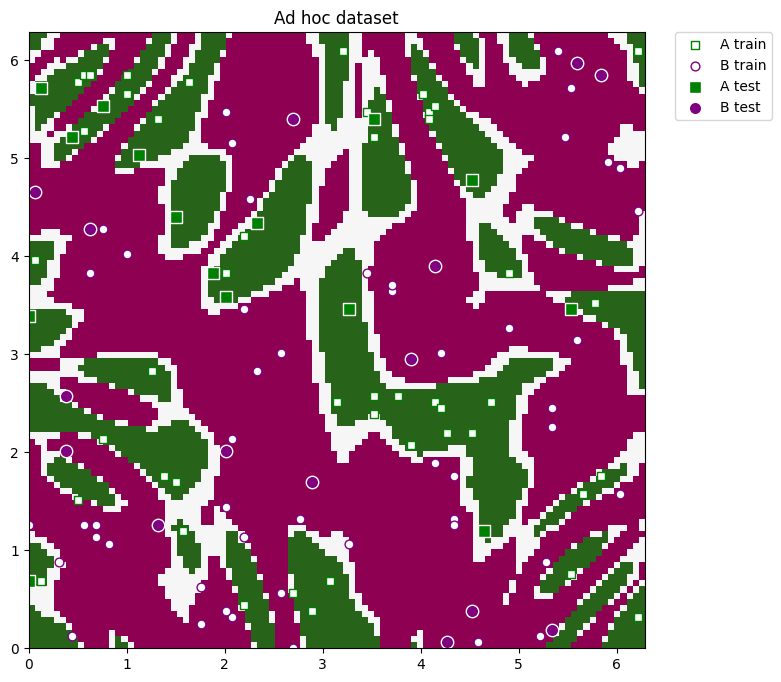

In [4]:
import matplotlib.pyplot as plt
import numpy as np


def plot_features(ax, features, labels, class_label, marker, face, edge, label, s):
    # A train plot
    ax.scatter(
        # x coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 0],
        # y coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 1],
        marker=marker,
        facecolors=face,
        edgecolors=edge,
        label=label,
        s=s
    )


def plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total):

    plt.figure(figsize=(8, 8))
    plt.ylim(0, 2 * np.pi)
    plt.xlim(0, 2 * np.pi)
    plt.imshow(
        np.asmatrix(adhoc_total).T,
        interpolation="nearest",
        origin="lower",
        cmap="PiYG",
        extent=[0, 2 * np.pi, 0, 2 * np.pi],
    )

    # A train plot
    plot_features(plt, train_features, train_labels, 0, "s", "w", "g", "A train", 40)

    # B train plot
    plot_features(plt, train_features, train_labels, 1, "o", "w", "purple", "B train", 40)

    # A test plot
    plot_features(plt, test_features, test_labels, 0, "s", "g", "w", "A test", 80)

    # B test plot
    plot_features(plt, test_features, test_labels, 1, "o", "purple", "w", "B test", 80)

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.title("Ad hoc dataset")

    plt.show()

plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total)

## Defining the Quantum kernel
next, we define the quantum kernel. 

This entails encoding our ad hoc data into a quantum state through use of a featrue map, here the ZZfeaturemap, and computes the similarity between the class states. Interestignly, it does this this trhoguht he use of fidelity, a quantum distance metric which is used in the Quantum SafeML method. This implies the data's compatibility with the range of quantumd istance emtrics the method employs at later stages.

Finally, the result of this computation is returned as the kernel value.

In [5]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

## State Vectors
Next, we use the Statevector feature from qiskit.quantum_info, the cosntructing a fucntion which will return the specific vectors of each of our quanutm states through use fo a new feature map.

In [6]:
from qiskit.quantum_info import Statevector

def get_statevectors(feature_map, data):
    statevecs = []
    for x in data:
        # Create a new instance of the feature map circuit
        circuit = feature_map.assign_parameters(x)
        # Simulate the final statevector
        sv = Statevector(circuit)
        statevecs.append(sv.data)  # .data gives the numpy array
    return statevecs

statevectors = get_statevectors(adhoc_feature_map, train_features)

## Provisional Distance Metric Assessment
The Quantum SafeML method specifies a range of different distance metrics that can be computed on a dataset. In the kernel method, fidelity, one such metric, is already employed. Here, we expand this computation to include other similar distance measures. Specifically, the metrics we calculate here are fidelity, trace distance, and Bures distance.

### Fidelity
This metric tells us how similar two quantum states are, with 1 indicating a high similarity. In kernel methods, this matrix becomes our kernel — the dot product in quantum feature space.

### Trace Distance
A full quantum distance metric measuring how distinguishable two quantum states are. It behaves as the inverse of fidelity: here, 1 denotes high distinguishability (completely orthogonal states), whereas 0 indicates complete overlap.

### Bures Distance
A middle ground between the two states, capable of picking up more subtle differences. Like trace distance, Bures distance denotes greater distinguishability as its value increases, but in a much smoother and more nuanced way.


In [7]:
from scipy.spatial.distance import cdist
import numpy as np

n = len(statevectors)
fidelity_matrix = np.zeros((n, n))
trace_distance_matrix = np.zeros((n, n))
bures_distance_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        psi = statevectors[i]
        phi = statevectors[j]

        # Fidelity
        fid = np.abs(np.vdot(psi, phi))**2
        fidelity_matrix[i, j] = fid

        # Trace distance: sqrt(1 - F) for pure states
        trace_distance_matrix[i, j] = np.sqrt(1 - fid)

        # Bures distance
        bures_distance_matrix[i, j] = np.sqrt(2 * (1 - np.sqrt(fid)))

## Visualising metric values
Below, we construct heatmaps of the metric values for each pairing of datapoints in the set. As expected, we observe diagonal lines in each heatmap, indicating complete overlap of each datapoint with itself. However, the other pairings show a much wider range of results.

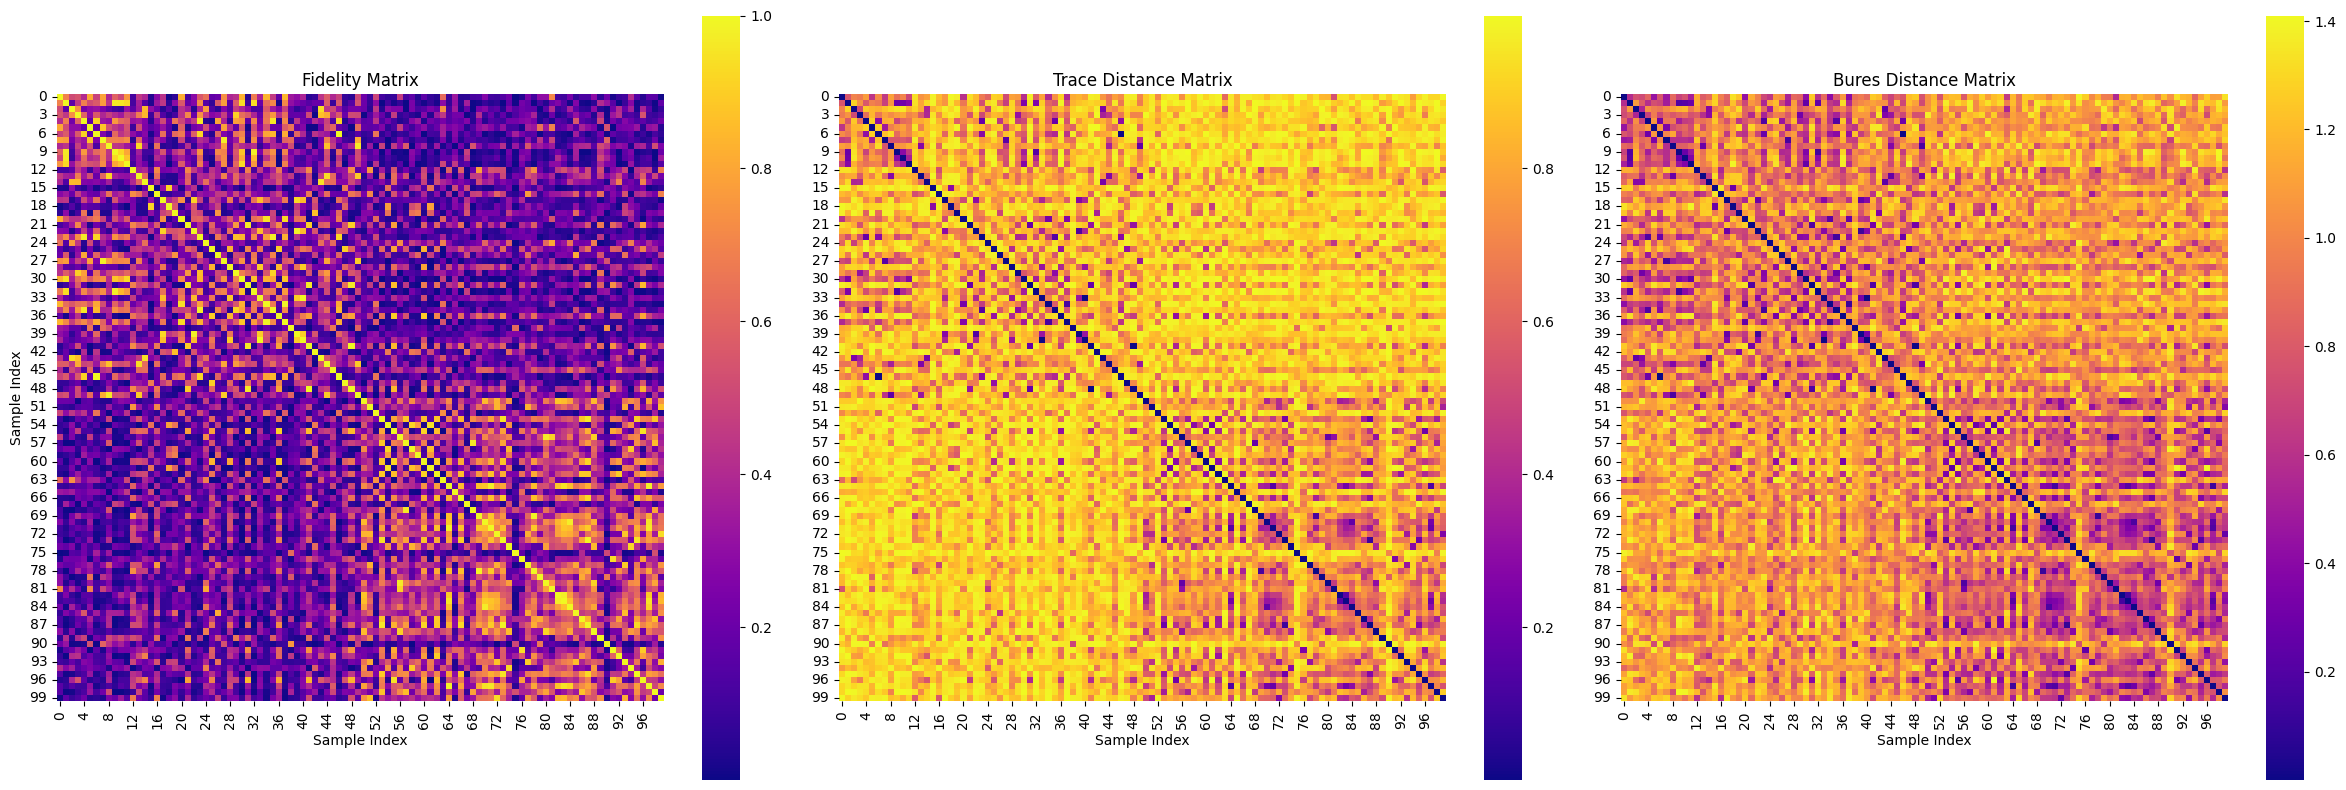

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns  # for a cleaner heatmap (optional but nice)
import numpy as np
# Set up a shared color theme for consistency
cmap = "plasma"  # or try "magma", "plasma", or your fave!

fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# Plot Fidelity Matrix
sns.heatmap(fidelity_matrix, ax=axs[0], cmap=cmap, square=True, cbar=True)
axs[0].set_title("Fidelity Matrix")
axs[0].set_xlabel("Sample Index")
axs[0].set_ylabel("Sample Index")

# Plot Trace Distance Matrix
sns.heatmap(trace_distance_matrix, ax=axs[1], cmap=cmap, square=True, cbar=True)
axs[1].set_title("Trace Distance Matrix")
axs[1].set_xlabel("Sample Index")
axs[1].set_ylabel("")

# Plot Bures Distance Matrix
sns.heatmap(bures_distance_matrix, ax=axs[2], cmap=cmap, square=True, cbar=True)
axs[2].set_title("Bures Distance Matrix")
axs[2].set_xlabel("Sample Index")
axs[2].set_ylabel("")

plt.tight_layout()
plt.show()

## Fitting data in a QSVC
QSVC stands for Quantum Support Vector Classifier, and is a quantum extension of a regular Support Vector Classifier. This type of QML (Quantum Machine Learning) model can be used for classification through the use of a quantum kernel, which was previously introduced through the computation of fidelity.

We instantiate the QSVC with this kernel and fit it to the training data, then score it using the test data.

In [9]:
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=adhoc_kernel)

qsvc.fit(train_features, train_labels)

qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 0.9333333333333333


## Visualise resutls of metric variation
Here we compute the metrics throughout the dataset at key indexes and measure these against eachtoher to show how the values vary.

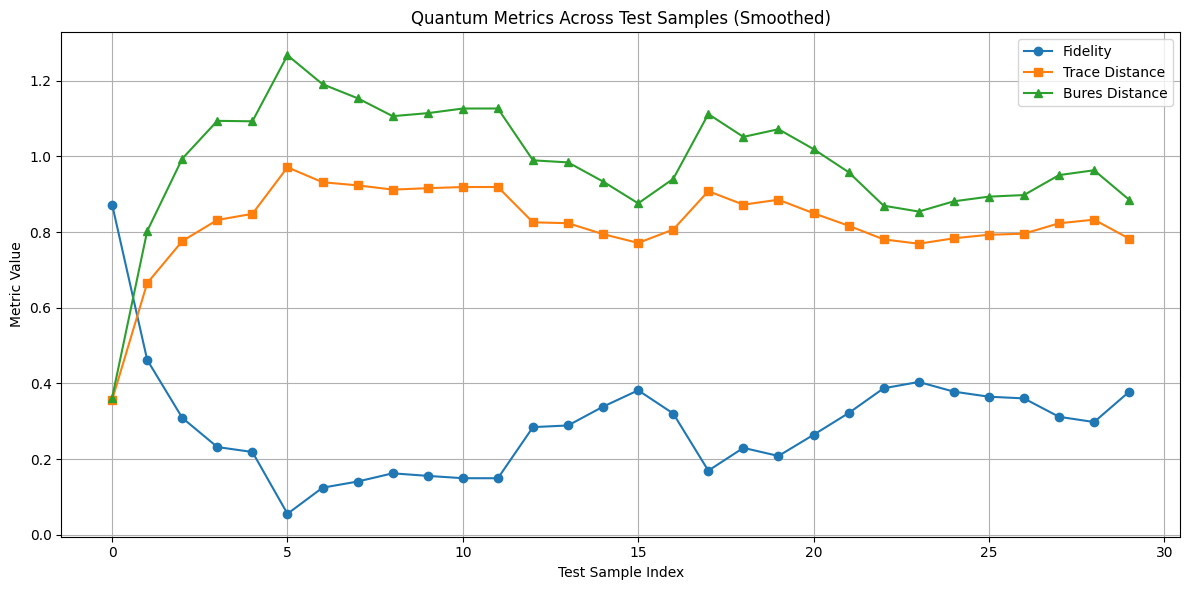

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from qiskit.quantum_info import Statevector, state_fidelity

# 🌀 Predict using the QSVC model
predicted_labels = qsvc.predict(test_features)

# 🧠 Function to get statevector from a data point
def get_statevector(x):
    return Statevector(adhoc_feature_map.assign_parameters(x))

# 🔍 Functions to compute distances
from scipy.linalg import sqrtm

def trace_distance(state1, state2):
    rho1 = state1.to_operator().data
    rho2 = state2.to_operator().data
    diff = rho1 - rho2
    sqrt_term = sqrtm(diff.conj().T @ diff)
    return 0.5 * np.trace(sqrt_term).real


def bures_distance(state1, state2):
    fidelity = state_fidelity(state1, state2)
    return np.sqrt(2 * (1 - np.sqrt(fidelity)))

# 🎯 Build centroid vectors for each class from training data
class_vectors = defaultdict(list)
for x, label in zip(train_features, train_labels):
    class_vectors[label].append(x)

class_centroids = {label: np.mean(vecs, axis=0) for label, vecs in class_vectors.items()}

# 🧪 Evaluate metrics
fidelities, trace_distances_list, bures_distances, true_classes = [], [], [], []

for x, label_pred in zip(test_features, predicted_labels):
    state_true = get_statevector(x)
    state_pred = get_statevector(class_centroids[label_pred])

    fidelities.append(state_fidelity(state_true, state_pred))
    trace_distances_list.append(trace_distance(state_true, state_pred))
    bures_distances.append(bures_distance(state_true, state_pred))
    true_classes.append(label_pred)

# 📊 Rolling mean every 5 points
def rolling_avg(lst, window=5):
    return [np.mean(lst[max(0, i - window + 1):i + 1]) for i in range(len(lst))]

x_axis = list(range(len(test_features)))
fidelity_smooth = rolling_avg(fidelities)
trace_smooth = rolling_avg(trace_distances_list)
bures_smooth = rolling_avg(bures_distances)

# 🖼️ Plot
plt.figure(figsize=(12, 6))
plt.plot(x_axis, fidelity_smooth, label='Fidelity', marker='o')
plt.plot(x_axis, trace_smooth, label='Trace Distance', marker='s')
plt.plot(x_axis, bures_smooth, label='Bures Distance', marker='^')
plt.title("Quantum Metrics Across Test Samples (Smoothed)")
plt.xlabel("Test Sample Index")
plt.ylabel("Metric Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Adding thresholds for human agent notification
Great, so we have our metric values — now what? In Quantum SafeML, we use these as references for model confidence and determine whether a human agent should be notified. To do this, we first specify a threshold value against which our metrics will be compared, and implement a method to notify human agents when this threshold is exceeded.

Some adjustments must be made first. We normalize the Bures distance: since Bures distance ranges from 0 to approximately 1.414 (the square root of 2), we shift it to align with the 0 to 1 range of the other metrics. We also invert fidelity so that a value of 1 indicates discrepancy, similar to the other metrics. Finally, we modify the code so that when the threshold is exceeded, the corresponding data points are appended to a list of unsafe datapoints, which will be presented to the user when appropriate.

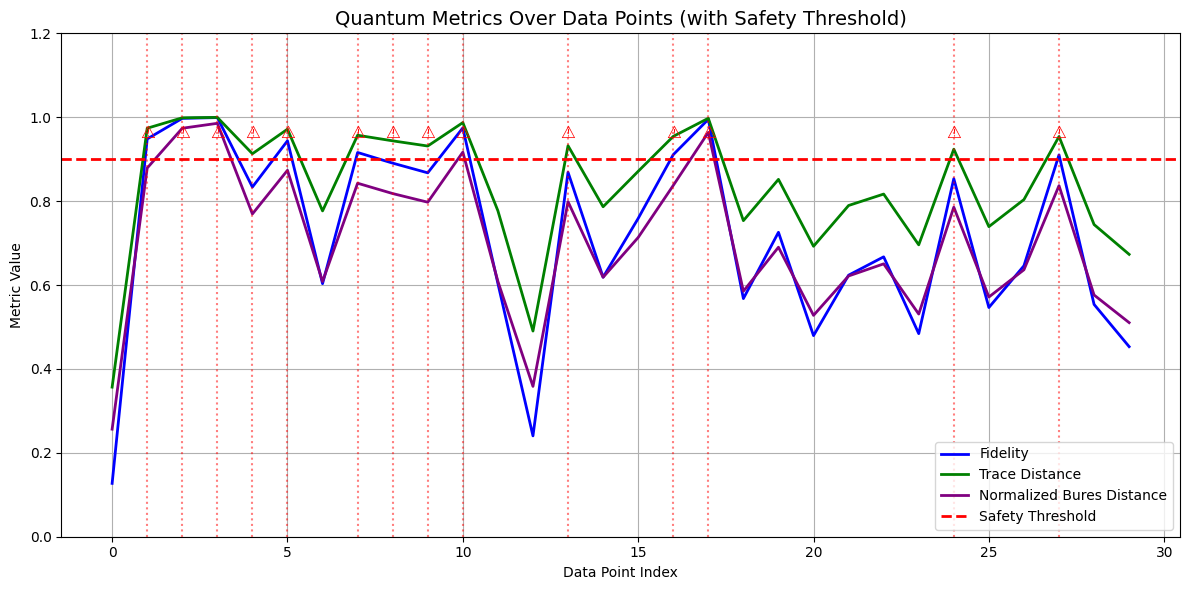


⚠️ SAFETY ALERTS:
HUMAN AGENT REQUIRED TO MONITOR ENTRY: Data Point 1
HUMAN AGENT REQUIRED TO MONITOR ENTRY: Data Point 2
HUMAN AGENT REQUIRED TO MONITOR ENTRY: Data Point 3
HUMAN AGENT REQUIRED TO MONITOR ENTRY: Data Point 4
HUMAN AGENT REQUIRED TO MONITOR ENTRY: Data Point 5
HUMAN AGENT REQUIRED TO MONITOR ENTRY: Data Point 7
HUMAN AGENT REQUIRED TO MONITOR ENTRY: Data Point 8
HUMAN AGENT REQUIRED TO MONITOR ENTRY: Data Point 9
HUMAN AGENT REQUIRED TO MONITOR ENTRY: Data Point 10
HUMAN AGENT REQUIRED TO MONITOR ENTRY: Data Point 13
HUMAN AGENT REQUIRED TO MONITOR ENTRY: Data Point 16
HUMAN AGENT REQUIRED TO MONITOR ENTRY: Data Point 17
HUMAN AGENT REQUIRED TO MONITOR ENTRY: Data Point 24
HUMAN AGENT REQUIRED TO MONITOR ENTRY: Data Point 27


In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Let's say this is our chosen safety threshold
threshold = 0.9  # You can tweak this
MAX_BURES = np.sqrt(2)

bures_distances_normalized = [bd / MAX_BURES for bd in bures_distances]
inverted_fidelities = [1 - f for f in fidelities]


# Plot setup
plt.figure(figsize=(12, 6))
x_vals = range(len(fidelities))

plt.plot(x_vals, inverted_fidelities, label="Fidelity", color="blue", linewidth=2)
plt.plot(x_vals, trace_distances_list, label="Trace Distance", color="green", linewidth=2)
plt.plot(x_vals, bures_distances_normalized, label="Normalized Bures Distance", color='purple', linewidth=2)


# 🚨 Threshold line
plt.axhline(y=threshold, color="red", linestyle="--", linewidth=2, label="Safety Threshold")
alert_indices = []
RED = "\033[91m"
RESET = "\033[0m"


# 🔍 Alert points
for i, (trace_d, bures_d, fid) in enumerate(zip(trace_distances_list, bures_distances_normalized, inverted_fidelities)):
    if trace_d > threshold or bures_d > threshold or fid > threshold:
        plt.axvline(x=i, color="red", linestyle=":", alpha=0.5)
        plt.text(i, threshold + 0.05, "⚠", ha='center', fontsize=12, color="red")
        alert_indices.append(i)

# Final plot polish
plt.title("Quantum Metrics Over Data Points (with Safety Threshold)", fontsize=14)
plt.xlabel("Data Point Index")
plt.ylabel("Metric Value")
plt.ylim(0, 1.2)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📢 Print alerts in red
if alert_indices:
    print(f"\n{RED}⚠️ SAFETY ALERTS:{RESET}")
    for idx in alert_indices:
        print(f"{RED}HUMAN AGENT REQUIRED TO MONITOR ENTRY: Data Point {idx}{RESET}")
else:
    print(f"\n{RED}✅ All data points are within safe bounds.{RESET}")

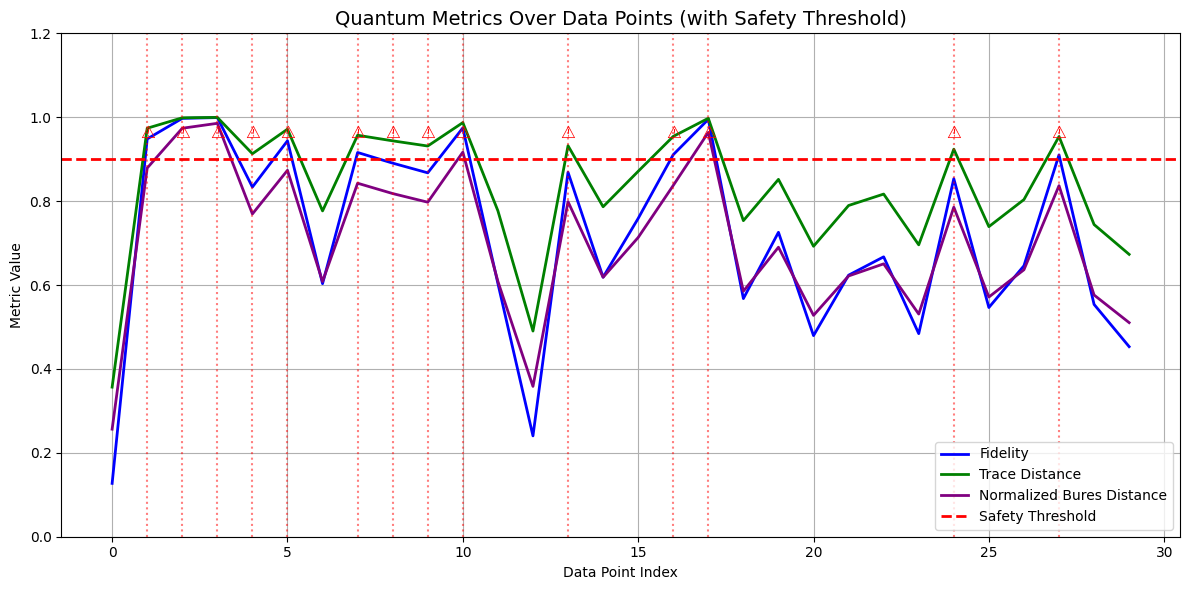


⚠️ SAFETY ALERTS:
HUMAN AGENT REQUIRED TO MONITOR ENTRY: Data Point 1
    True Label: 0
    Predicted Label: 0
HUMAN AGENT REQUIRED TO MONITOR ENTRY: Data Point 2
    True Label: 0
    Predicted Label: 1
HUMAN AGENT REQUIRED TO MONITOR ENTRY: Data Point 3
    True Label: 0
    Predicted Label: 1
HUMAN AGENT REQUIRED TO MONITOR ENTRY: Data Point 4
    True Label: 0
    Predicted Label: 0
HUMAN AGENT REQUIRED TO MONITOR ENTRY: Data Point 5
    True Label: 0
    Predicted Label: 0
HUMAN AGENT REQUIRED TO MONITOR ENTRY: Data Point 7
    True Label: 0
    Predicted Label: 0
HUMAN AGENT REQUIRED TO MONITOR ENTRY: Data Point 8
    True Label: 0
    Predicted Label: 0
HUMAN AGENT REQUIRED TO MONITOR ENTRY: Data Point 9
    True Label: 0
    Predicted Label: 0
HUMAN AGENT REQUIRED TO MONITOR ENTRY: Data Point 10
    True Label: 0
    Predicted Label: 0
HUMAN AGENT REQUIRED TO MONITOR ENTRY: Data Point 13
    True Label: 0
    Predicted Label: 0
HUMAN AGENT REQUIRED TO MONITOR ENTRY: Data Point

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Let's say this is our chosen safety threshold
threshold = 0.9  # You can tweak this
MAX_BURES = np.sqrt(2)

# Normalize Bures distances
bures_distances_normalized = [bd / MAX_BURES for bd in bures_distances]
inverted_fidelities = [1 - f for f in fidelities]

# Plot setup
plt.figure(figsize=(12, 6))
x_vals = range(len(fidelities))

plt.plot(x_vals, inverted_fidelities, label="Fidelity", color="blue", linewidth=2)
plt.plot(x_vals, trace_distances_list, label="Trace Distance", color="green", linewidth=2)
plt.plot(x_vals, bures_distances_normalized, label="Normalized Bures Distance", color='purple', linewidth=2)

# 🚨 Threshold line
plt.axhline(y=threshold, color="red", linestyle="--", linewidth=2, label="Safety Threshold")
alert_indices = []
RED = "\033[91m"
RESET = "\033[0m"

# 🔍 Alert points
for i, (trace_d, bures_d, fid) in enumerate(zip(trace_distances_list, bures_distances_normalized, inverted_fidelities)):
    if trace_d > threshold or bures_d > threshold or fid > threshold:
        plt.axvline(x=i, color="red", linestyle=":", alpha=0.5)
        plt.text(i, threshold + 0.05, "⚠", ha='center', fontsize=12, color="red")
        alert_indices.append(i)

# Final plot polish
plt.title("Quantum Metrics Over Data Points (with Safety Threshold)", fontsize=14)
plt.xlabel("Data Point Index")
plt.ylabel("Metric Value")
plt.ylim(0, 1.2)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📢 Print alerts in red, with labels
if alert_indices:
    print(f"\n{RED}⚠️ SAFETY ALERTS:{RESET}")
    for idx in alert_indices:
        print(f"{RED}HUMAN AGENT REQUIRED TO MONITOR ENTRY: Data Point {idx}")
        print(f"    True Label: {test_labels[idx]}")
        print(f"    Predicted Label: {predicted_labels[idx]}{RESET}")
else:
    print(f"\n{RED}✅ All data points are within safe bounds.{RESET}")


## conclusion
Overall, this kernel presents a simple concept of how Quantum SafeMl can be employed to quantum machine learning problems. We employ the differeny distance metrics and modify them for the specific purpsoes of threshold based safety monitoring, and the ad hoc dataset serves as a proof of concept for various types of classification problems. Whilst Quantum classification is still in it's early stages, it's potential is vast, and so preparing safety measures for it is of critical importance for future works.